Notebook initialized 8/3/2020.  *must connect to google drive*


The purpose of this notebook is to create a data-generator that can be used with my keras workflow. I want to be able to augment images (and masks simultanously) on the fly. 

testing data is 110 images/labels from RC0220Ra located:
'/content/drive/My Drive/Colab_Notebooks/image_augmentation/IMAGES'
'/content/drive/My Drive/Colab_Notebooks/image_augmentation/LABELS'



In [1]:
import datetime as dt
current_time = dt.datetime.now()
print(f"notebook last updated: {current_time}")

notebook last updated: 2020-08-03 23:33:36.457468


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

In [2]:
import numpy as np
from PIL import Image, ImageFilter
import cv2
from glob import glob 
from imageio import imread, imwrite
from skimage.transform import resize
import imgaug as ia
import matplotlib.pyplot as plt
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import os


In [3]:
images_dir =  '/content/drive/My Drive/Colab_Notebooks/image_augmentation/IMAGES'
labels_dir = '/content/drive/My Drive/Colab_Notebooks/image_augmentation/LABELS'

print(len(os.listdir(images_dir)), "-images")
print(len(os.listdir(labels_dir)), "-labels")

110 -images
110 -labels


In [4]:
def get_image_list(path, exts = ['.JPG','.jpg']):
  filelist = os.listdir(path)
  images_list = [f for f in filelist if f.endswith(tuple(exts))]
  images_list = sorted(images_list)
  #print(f'files in {path}:\n {images_list}')
  return images_list

In [5]:
image_file_list = get_image_list(images_dir)
label_file_list = get_image_list(labels_dir, exts = [".PNG", ".png"])

# for image, label in zip(image_file_list, label_file_list):
#   print(f'{image}:-:{label}')

In [6]:
image_file_path_list = []
for image in image_file_list :
  image_path = images_dir + os.sep + image
  image_file_path_list.append(image_path)

label_file_path_list = []
for label in label_file_list :
  label_path = labels_dir + os.sep + label
  label_file_path_list.append(label_path)



In [7]:
def image_generator(image_files, label_files ,batch_size, sz):
  while True:
    #extract a random batch of image files
    batch_index = np.random.choice(len(image_files), size = batch_size, replace = False)

    #variables for collecting batches of inputs and outputs
    batch_x = []
    batch_y = []

    for i in batch_index:

        #get the masks. Note that masks are png files
        mask = Image.open(glob(label_files[i])[0])
        mask = np.array(mask.resize(sz))
        mask[mask == 0 ] = 0
        mask[mask > 0] = 1

        batch_y.append(mask)

        #preprocess the raw images
        raw = Image.open(image_files[i])
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        #raw = ((raw - np.mean(raw))/np.std(raw))#.astype('uint8')

        batch_x.append(raw/255.)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x)#/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)#/255.

    yield (batch_x, batch_y)


In [8]:
def image_augmentation(imgs, masks): 
    #  create two instances with the same arguments
    # create dictionary with the input augmentation values
    data_gen_args = dict(featurewise_center=False,
                         featurewise_std_normalization=False,
                         rotation_range=90.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2, 
                         horizontal_flip=True,
                         vertical_flip = True)
    ## use this method with both images and masks
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    ## fit the augmentation model to the images and masks with the same seed
    image_datagen.fit(imgs, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)
    ## set the parameters for the data to come from (images)
    image_generator = image_datagen.flow(
        imgs,
        batch_size=3,
        shuffle=True,
        seed=seed)
    ## set the parameters for the data to come from (masks)
    mask_generator = mask_datagen.flow(
        masks,
        batch_size=3,
        shuffle=True,
        seed=seed)

    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    ## return the train generator for input in the CNN 
    return train_generator

In [9]:
import imgaug as ia
import imgaug.augmenters as iaa
#!pip install imgaug

In [10]:
seq = iaa.Sequential([iaa.Fliplr(.5), iaa.GammaContrast((0.5, 2.0)),iaa.PiecewiseAffine(scale=(0.01, 0.05))])

def augment_seg(img, lab):
  aug_det = lab.to_deterministic()
  image_aug = aug_det.augment_images(img)
  segmap = ia.SegmentationMapOnImage(lab, shape = img.shape )
  segmap_aug = aug_det.augment_segmentation_maps(segmap)
  segmap_aug = segmap_aug.get_arr_int()

  return image_aug, segmap_aug

In [11]:

train_generator = image_generator(image_file_path_list, label_file_path_list, 3, (128,128))

In [12]:
X,Y = next(train_generator)


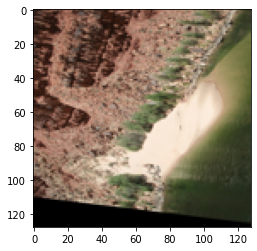

In [13]:
plt.imshow(X[0])


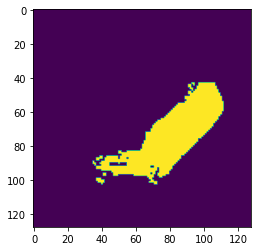

In [14]:
plt.imshow(Y[0].squeeze())

In [15]:
from imgaug import augmenters as iaa
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from scipy import misc
import imageio 
import numpy as np
from PIL import Image, ImageDraw